# Binary Classification with a Software Defects Dataset
Playground Series - Season 3, Episode 23
https://www.kaggle.com/competitions/playground-series-s3e23/data

In [1]:
# Libraries
import numpy as np
import pandas as pd

from preprocessing import read_train, read_test, SMOTE_data, transform_X

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

### Data

In [2]:
X, y = read_train(original=True)
X, y = SMOTE_data(X, y)

In [3]:
from collections import Counter
(counter := Counter(y))

Counter({False: 65608, True: 43739})

In [3]:
# As discover in the EDA, we will log transform all X for better distribution
log_X = np.log(X + .001)

In [4]:
# Transform data into Standard scale
ss = StandardScaler()
fit_X = ss.fit_transform(log_X)
fit_Y = y.copy().to_numpy()

In [5]:
# 
xtrain, xtest, ytrain, ytest = train_test_split(fit_X, y, test_size=.3)

### Models

In [6]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

rs = 93

In [12]:
# SVM
svc = svm.SVC().fit(xtrain, ytrain)
svc_pred = svc.predict(xtest)
print("Accuracy:", accuracy_score(ytest, svc_pred))
print("ROC/AUC Score:", roc_auc_score(ytest, svc_pred))

Accuracy: 0.738515470202713
ROC/AUC Score: 0.7082073542645551


In [7]:
# RandomForest
rf = RandomForestClassifier().fit(xtrain, ytrain)
rf_pred = rf.predict(xtest)
print("Accuracy:", accuracy_score(ytest, rf_pred))
print("ROC/AUC Score:", roc_auc_score(ytest, rf_pred))

Accuracy: 0.8072854747751868
ROC/AUC Score: 0.7878559298251543


In [10]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5).fit(xtrain, ytrain)
knn_pred = knn.predict(xtest)
print("Accuracy:", accuracy_score(ytest, knn_pred))
print("ROC/AUC Score:", roc_auc_score(ytest, knn_pred))

Accuracy: 0.7387898186252095
ROC/AUC Score: 0.7213182226084673


In [9]:
# Logistic Regression
lr = LogisticRegression(random_state=rs, max_iter=1000).fit(xtrain, ytrain)
lr_pred = lr.predict(xtest)
print("Accuracy:", accuracy_score(ytest, lr_pred))
print("ROC/AUC Score:", roc_auc_score(ytest, lr_pred))

Accuracy: 0.7347050754458162
ROC/AUC Score: 0.7064375084555259


### Prediction

In [8]:
pred_X, id = read_test()

In [10]:
pred_X = transform_X(pred_X)

In [12]:
pred = rf.predict_proba(pred_X)

In [13]:
output = pd.DataFrame({"id": id, "defects": pred[:, 1]})

In [14]:
#output.to_csv("prediction.csv", index=False)

### Voting Classifier
https://www.kaggle.com/code/iqbalsyahakbar/ps3e23-binary-classification-for-beginners#Loading-Libraries-and-Datasets

In [15]:
from category_encoders import OneHotEncoder, GLMMEncoder, TargetEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [16]:
seed = 93
splits = 5
skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
np.random.seed(seed)

In [17]:
def cross_val_score(estimator, cv=skf, label=''):
    
    X = fit_X.copy()
    y = fit_Y.copy()
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    #train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        
        #define validation set
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                  
        val_predictions[val_idx] += val_preds
        
        #evaluate model for a fold
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [18]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000)),
    #('svc', SVC(random_state = seed, probability = True)),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    #('knn', KNeighborsClassifier()),
    #('gauss', GaussianProcessClassifier(random_state = seed)),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

for (label, model) in models:
    score_list[label], oof_list[label] = cross_val_score(
        make_pipeline(SimpleImputer(), model),
        label = label
    )

Val Score: 0.77959 ± 0.00390 | Train Score: 0.77985 ± 0.00097 | log
Val Score: 0.77838 ± 0.00414 | Train Score: 0.77860 ± 0.00097 | lda
Val Score: 0.74714 ± 0.00494 | Train Score: 0.74717 ± 0.00120 | gnb
Val Score: 0.74518 ± 0.00496 | Train Score: 0.74519 ± 0.00128 | bnb
Val Score: 0.86645 ± 0.00281 | Train Score: 0.99969 ± 0.00003 | rf
Val Score: 0.85971 ± 0.00277 | Train Score: 0.99998 ± 0.00000 | et
Val Score: 0.85866 ± 0.00265 | Train Score: 0.89347 ± 0.00097 | xgb
[LightGBM] [Info] Number of positive: 34991, number of negative: 52486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4811
[LightGBM] [Info] Number of data points in the train set: 87477, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400002 -> initscore=-0.405456
[LightGBM] [Info] Start training from score -0.405456
[LightGBM] [Info] Number of posi

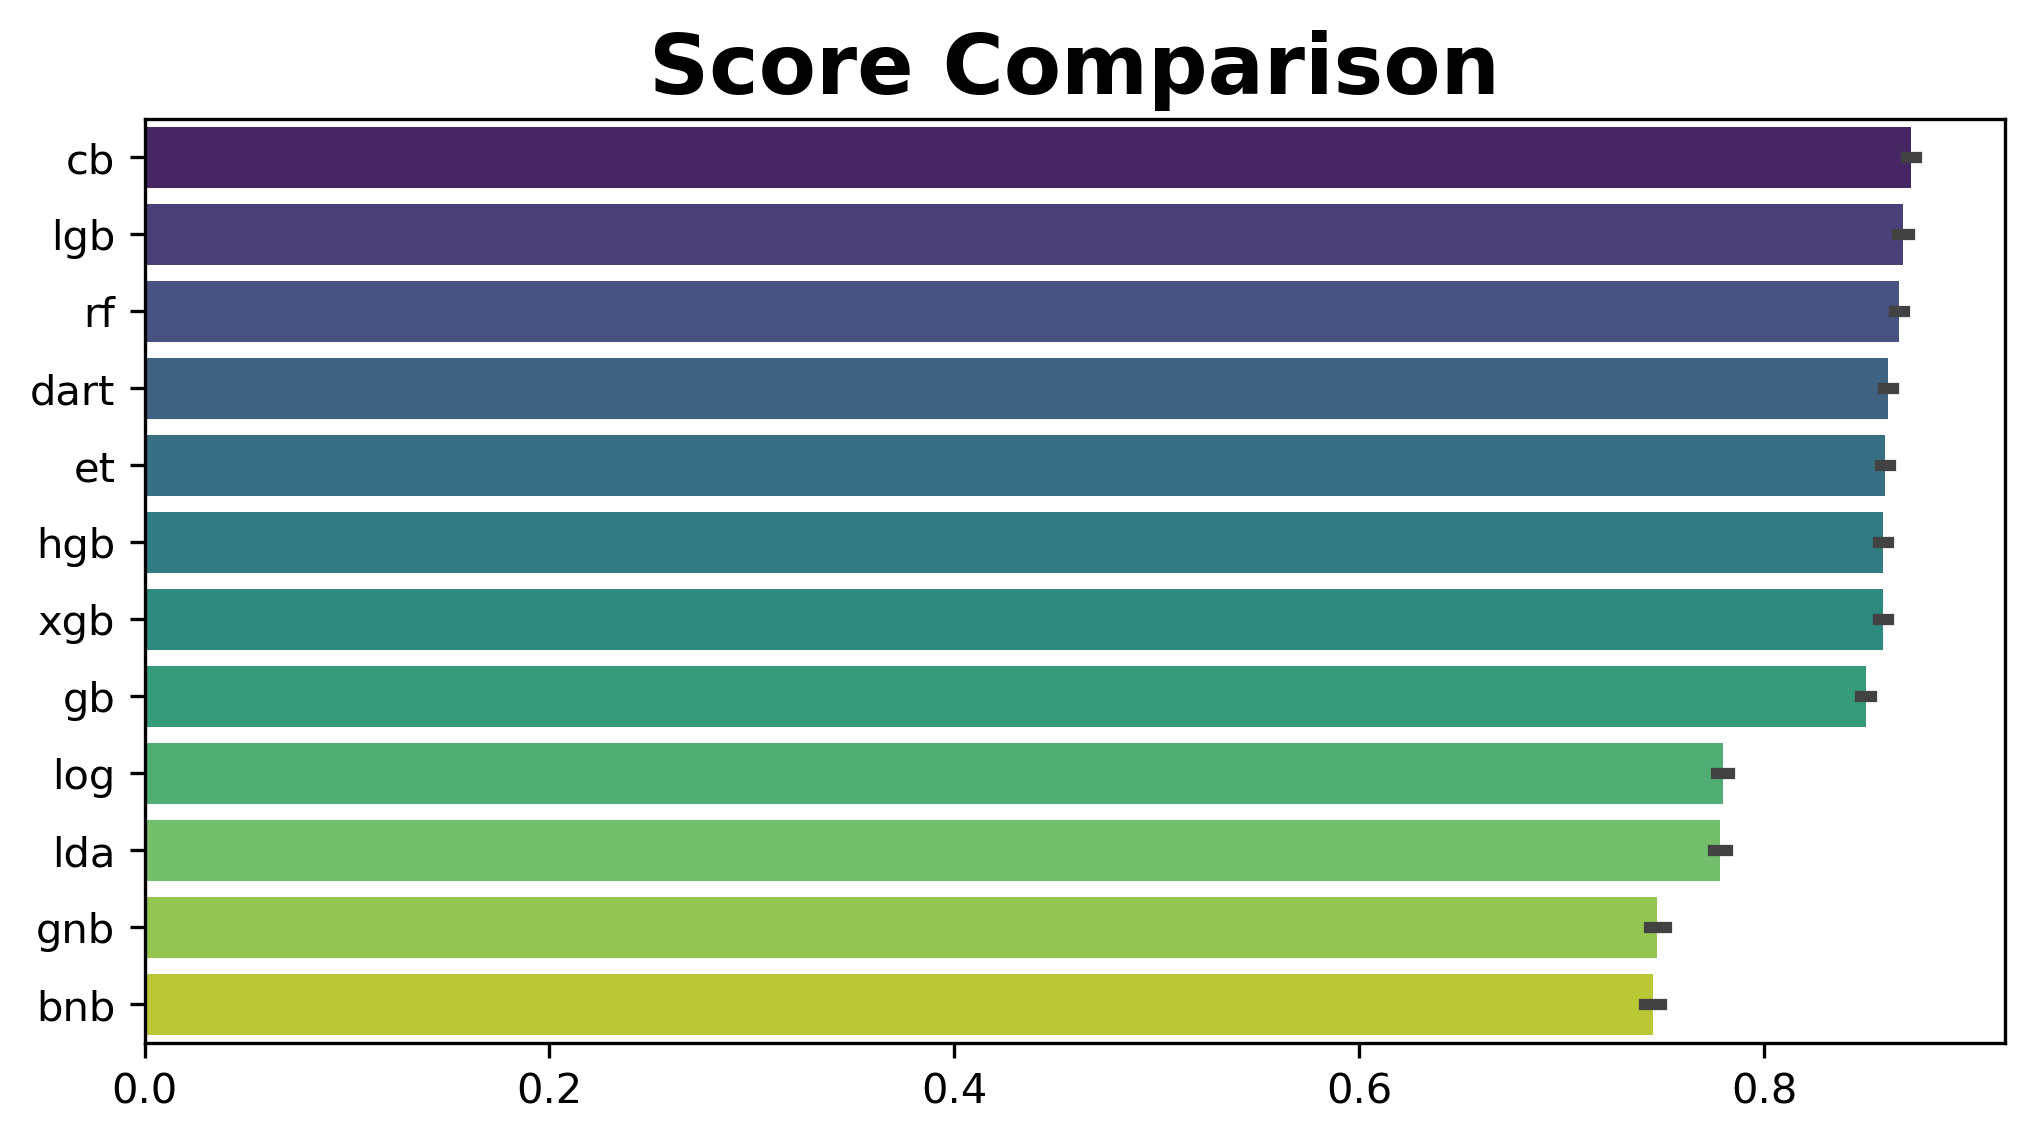

In [19]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()

In [20]:
weights = RidgeClassifier(random_state = seed).fit(oof_list, y).coef_[0]
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
log,-0.146764
lda,-0.137065
gnb,-0.001946
bnb,-0.020817
rf,-0.107562
et,0.949214
xgb,-0.097329
lgb,0.759461
dart,0.053497
cb,1.463821


In [21]:
voter = VotingClassifier(models, weights = weights, voting = 'soft')
_ = cross_val_score(make_pipeline(SimpleImputer(), voter))

[LightGBM] [Info] Number of positive: 34991, number of negative: 52486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4811
[LightGBM] [Info] Number of data points in the train set: 87477, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400002 -> initscore=-0.405456
[LightGBM] [Info] Start training from score -0.405456
[LightGBM] [Info] Number of positive: 34991, number of negative: 52486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4811
[LightGBM] [Info] Number of data points in the train set: 87477, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400002 -> initscore=-0.405456
[LightGBM] [Info] Start training from score -0.405456
[LightGBM] [

In [22]:
model = make_pipeline(
    SimpleImputer(),
    voter
)

In [23]:
model.fit(fit_X, fit_Y)

[LightGBM] [Info] Number of positive: 43739, number of negative: 65608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4821
[LightGBM] [Info] Number of data points in the train set: 109347, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400002 -> initscore=-0.405457
[LightGBM] [Info] Start training from score -0.405457
[LightGBM] [Info] Number of positive: 43739, number of negative: 65608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4821
[LightGBM] [Info] Number of data points in the train set: 109347, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400002 -> initscore=-0.405457


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('log',
                                               LogisticRegression(max_iter=1000000,
                                                                  random_state=93)),
                                              ('lda',
                                               LinearDiscriminantAnalysis()),
                                              ('gnb', GaussianNB()),
                                              ('bnb', BernoulliNB()),
                                              ('rf',
                                               RandomForestClassifier(random_state=93)),
                                              ('et',
                                               ExtraTreesClassifier(random_state=93)),
                                              ('xgb',
                                               XGBClassifi...
                                                              random_state=93)),
                                              ('cb',
                                               <catboost.core.CatBoostClassifier object at 0x000001A4E4086DD0>),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=93)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=93))],
                                  voting='soft',
                                  weights=array([-0.1467642 , -0.13706485, -0.00194611, -0.02081692, -0.10756233,
        0.94921423, -0.09732878,  0.75946096,  0.05349717,  1.46382138,
       -0.47207559, -0.22814265])))])

In [51]:
pred_X, id = read_test()

In [52]:
pred_X = transform_X(pred_X)

In [24]:
pred = model.predict_proba(pred_X)

In [26]:
pred

array([[ 0.08521706,  0.91478294],
       [ 0.1038907 ,  0.8961093 ],
       [ 0.04372184,  0.95627816],
       ...,
       [ 0.02647826,  0.97352174],
       [-0.00826584,  1.00826584],
       [ 0.11950661,  0.88049339]])

In [25]:
output = pd.DataFrame({"id": id, "defects": pred[:, 1]})

In [27]:
output.to_csv("prediction.csv", index=False)

In [28]:
sum(output.defects < 0.5)

42